In [2]:
import os
import random
import warnings

import matplotlib.pyplot as plt
import simplstyles
import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from residual import residual_method
from simulation import generate_dataset
from variance_partitioning import variance_partitioning

In [12]:
plt.style.use('nord-light-talk')

In [3]:
def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying noise")
    os.makedirs(path, exist_ok=True)
    return path

In [4]:
def get_experiments(alphas, cv, n_targets):
    path = get_path(alphas, cv, n_targets)
    experiments = []
    for file in os.listdir(path):
        if file.endswith(".csv"):
            variable = file.split("_")[1].split(".csv")[0]
            # parse variable
            noise = float(variable)
            experiments.append(noise)
    return experiments

In [5]:
def save_scores(noise_levels, d_list, scalars, n_targets, n_samples, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for noise_target in noise_levels:
        print(noise_target)
        csv_path = os.path.join(path, f"scores_{noise_target}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score
        print(scores.head())

        x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score

        # ridge residual
        x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv, use_ols=False)
        print("residual method done")
        scores["rm_ridge_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x2_to_x1_ridge_score), np.nan)])
        scores["rm_ridge_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_ridge_score, np.full(len(rm_ridge_x1_unique_score) - len(x1_to_x2_ridge_score), np.nan)])
        scores["rm_ridge_x1_unique_score"] = rm_ridge_x1_unique_score
        scores["rm_ridge_x2_unique_score"] = rm_ridge_x2_unique_score
        del x2_to_x1_ridge_score, x1_to_x2_ridge_score, rm_ridge_x1_unique_score, rm_ridge_x2_unique_score
        del Xs, Y
        scores.to_csv(csv_path, index=False)

# Save scores for varying noise levels

In [6]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)
plt.style.use('nord-light-talk')

/home/leo/PycharmProjects/compare_variance_residual/venv/lib/python3.12/site-packages/himalaya/backend/_utils.py:55: UserWarning: Setting backend to cupy failed: Cupy not installed..Falling back to numpy backend.
  warnings.warn(f"Setting backend to {backend} failed: {str(error)}."


In [7]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
scalars = [1 / 3, 1 / 3, 1 / 3]

cv = 10
alphas = np.logspace(-5, 5, 10)

In [8]:
nstep = 11
noise_levels = np.linspace(0, 1, nstep)
noise_levels

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
save_scores(noise_levels, d_list, scalars, n_targets, n_samples, cv, alphas)

0.0
skipping, already exists
0.1
skipping, already exists
0.2
skipping, already exists
0.30000000000000004
skipping, already exists
0.4
skipping, already exists
0.5
skipping, already exists
0.6000000000000001
skipping, already exists
0.7000000000000001
skipping, already exists
0.8
skipping, already exists
0.9
skipping, already exists
1.0
skipping, already exists


# Plot scores

In [10]:
vp = pd.DataFrame()
rm = pd.DataFrame()
rm_ridge = pd.DataFrame()

all_levels = get_experiments(alphas, cv, n_targets)
print(all_levels)
for i, noise_level in enumerate(all_levels):
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{noise_level}.csv"))
    vp_x1_unique_predicted = scores['vp_x1_unique_score']
    vp_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'vp_x1_unique_score': vp_x1_unique_predicted,
    }, index=range(len(vp_x1_unique_predicted)))

    rm_x1_unique_score = scores['rm_x1_unique_score']
    rm_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'rm_x1_unique_score': rm_x1_unique_score,
    }, index=range(len(vp_x1_unique_predicted)))

    rm_ridge_x1_unique_score = scores['rm_ridge_x1_unique_score']
    rm_ridge_scores = pd.DataFrame({
        'noise_target': [noise_level] * len(vp_x1_unique_predicted),
        'rm_ridge_x1_unique_score': rm_ridge_x1_unique_score,
    }, index=range(len(vp_x1_unique_predicted)))

    vp = pd.concat([vp, vp_scores], ignore_index=True)
    rm = pd.concat([rm, rm_scores], ignore_index=True)
    rm_ridge = pd.concat([rm_ridge, rm_ridge_scores], ignore_index=True)
vp.head()

[0.2, 0.4, 0.6000000000000001, 0.15000000000000002, 0.0, 1.0, 0.1, 0.30000000000000004, 0.7000000000000001, 0.9, 0.05, 0.5, 0.8, 0.25]


,noise_target,vp_x1_unique_score
0,0.2,0.297937
1,0.2,0.245999
2,0.2,0.242876
3,0.2,0.226376
4,0.2,0.312488


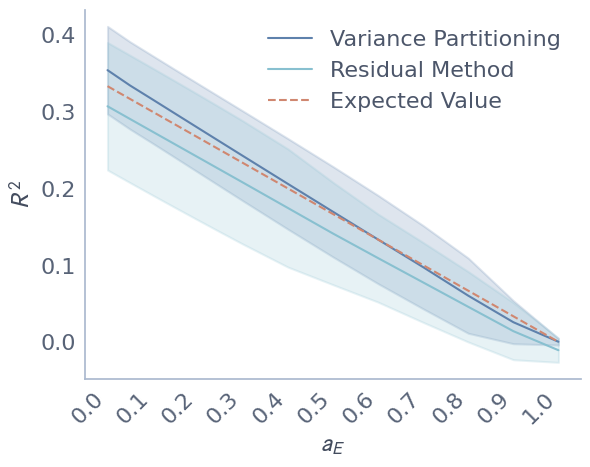

In [20]:
sns.lineplot(data=vp, x='noise_target', y='vp_x1_unique_score', label='Variance Partitioning', errorbar='sd')
sns.lineplot(data=rm, x='noise_target', y='rm_x1_unique_score', label='Residual Method (OLS)', errorbar='sd')
sns.lineplot(data=rm_ridge, x='noise_target', y='rm_ridge_x1_unique_score', label='Residual Method (Ridge)', errorbar='sd')
expected_values = scalars[1] * (1 - noise_levels)
plt.plot(noise_levels, expected_values, linestyle='--', label='Expected Value')
plt.xlabel(r"$a_E$")
plt.xticks(noise_levels, labels=[f"{noise:.1f}" for noise in noise_levels] , rotation=45, ha='right')
plt.ylabel(r"$R^2$")
plt.legend()